In [58]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Урок 8. Снижение размерности данных.
1. Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [10]:
def e_metrics(x1, x2):
    distance = np.sum(np.square(x1 - x2))
    return np.sqrt(distance)

In [11]:
def knn(x_train, y_train, x_test, k):

    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            distance = e_metrics(x, x_train[i])# расчет расстояния до объекта обучающей выборки
                
            test_distances.append((distance, y_train[i]))# Значение расстояния и ответа на объекте обучающей выборки
            
        classes = {class_item: 0 for class_item in set(y_train)}
         
        for d in sorted(test_distances)[0:k]:# Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
            classes[d[1]] += 1
        answers.append(sorted(classes, key=classes.get)[-1])# Записываем в список ответов наиболее часто встречающийся класс
        
    return answers

In [12]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [17]:
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [24]:
 k = 100

y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)

print(f'При k = {k} on train -> {accuracy(y_pred_train, y_train):.3f}')
print(f'При k = {k} on tesst -> {accuracy(y_pred, y_test):.3f}')

При k = 100 on train -> 0.500
При k = 100 on tesst -> 0.467


Обработаем данные при помощи PCA

In [25]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [26]:
X = X.astype(float)
X = standard_scale(X)

In [27]:
covariance_matrix = X.T @ X#собственные векторы и собственные значения

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)# Cортируею список по убыванию собственных значений

Оценю долю дисперсии, которая описывается найденными компонентами.

In [29]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]#Доля дисперсии, описываемая каждой из компонент
cum_var_exp = np.cumsum(var_exp)#Кумулятивная (то есть накапливаемую) дисперсию при учитывании каждой из компонент
var_exp, cum_var_exp

([72.9624454132999, 22.850761786701742, 3.6689218892828745, 0.517870910715477],
 array([ 72.96244541,  95.8132072 ,  99.48212909, 100.        ]))

Первые две компоненты описывают 94% информации. Отбрасываю две последние компоненты.  
Сформирую вектор весов из собственных векторов, соответствующих первым двум главным компонентам.

In [31]:
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])#Матрица весов W
W

array([[ 0.52106591, -0.37741762],
       [-0.26934744, -0.92329566],
       [ 0.5804131 , -0.02449161],
       [ 0.56485654, -0.06694199]])

In [32]:
Z = X.dot(W)#Новая матрицу "объекты-признаки"

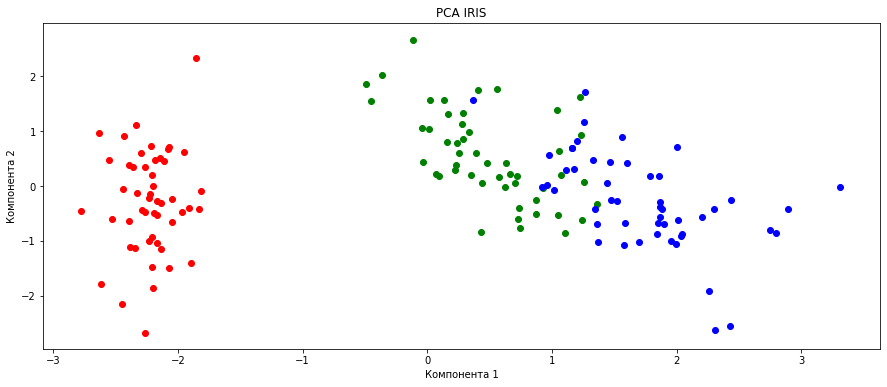

In [57]:
plt.figure(figsize=(15, 6))
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.title('PCA IRIS')
plt.show()

Качество knn при отбрасывании двух последних компонент

In [44]:
X_cutted = X[:, :2]
X_train, X_test, y_train, y_test = train_test_split(X_cutted, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
k = 100
y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)
print(f'При k = {k} on train -> {accuracy(y_pred_train, y_train):.3f}')
print(f'При k = {k} on tesst -> {accuracy(y_pred, y_test):.3f}')

При k = 100 on train -> 0.758
При k = 100 on tesst -> 0.667


Качество knn при применении PCA

In [47]:
X_train, X_test, y_train, y_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
k = 100
y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)
print(f'При k = {k} on train -> {accuracy(y_pred_train, y_train):.3f}')
print(f'При k = {k} on tesst -> {accuracy(y_pred, y_test):.3f}')

При k = 100 on train -> 0.675
При k = 100 on tesst -> 0.567


### Вывод
До применения PCA точность алгоритма на трейне при k = 100 -> 0.500, на тесте при k = 100 -> 0.467
При отбрасывании двух последних малозначащих признаков точность алгоритма на трейне при k = 100 -> 0.758, на тесте при k = 100 -> 0.667
После применения PCA точность алгоритма на трейне при k = 100 -> 0.675, на тесте при k = 100 -> 0.567  
При применении PCA наблюдаем увеличение качества модели на 10-17%
При отбрасывании малозначащих признаков наблюдаем увеличение качества модели на 20-25%

## Задание 2
*Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [48]:
def pca_sdv(X, d=1):
    X_T_X = X.T @ X
    U, s, W = np.linalg.svd(X_T_X)

    V = W.T
    
    pairs = sorted([[idx, item] for idx, item in enumerate(s)], key=lambda item: item[1])
    pairs.reverse()
    
    pairs = np.array(pairs, dtype=int)
    
    max_pairs = pairs[:d]
    max_ids = max_pairs[:, 0]
    
    WEIGHTS = V[max_ids].T
    
    return X @ WEIGHTS

In [54]:
Z_PCA_SDV = pca_sdv(X, 2)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(Z_PCA_SDV, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [56]:
k = 100
y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)
print(f'При k = {k} on train -> {accuracy(y_pred_train, y_train):.3f}')
print(f'При k = {k} on tesst -> {accuracy(y_pred, y_test):.3f}')

При k = 100 on train -> 0.675
При k = 100 on tesst -> 0.700
